# <center>Analysis of How Adding Opponent Modelling Compares to a Basic Hyperplayer</center>

This file is an interactive notebook to analyze the data obtained from tests.<br>
The opponent modelling agent is a variant on the basic hyperplayer that uses MCS to determine the relative quality of each possible move and expanding the hypergame set by selecting moves that the opponent is more likely to make from a given state.

This variant updates the state to better handle the 0 case

I will be using kriegTTT_4x4 because this is a more complex game. 

Hyperplayer Params:<br>
numHyperGames = 16<br>
numHyperBranches = 4<br>
numProbes = 4

OP Hyperplayer_64 Params:<br>
numHyperGames = 16<br>
numHyperBranches = 4<br>
numOPprobes = 32<br>
numProbes = 16

## Reading in the Data

First the match data must be read in.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics
np.random.seed(42)

# Read in the csv files
numNames = ['ophyperb_wupdate']
data = list()

for idx, name in enumerate(numNames):
    file_name = '../testOutput/kriegTTT_4x4/' + name + '/testOutput.csv'
    data.append(pd.DataFrame)
    data[idx] = pd.read_csv(file_name, header=0)

# Print the first 5 rows of the data
for game in data:
    display(game.head())

,match_id,game_name,gdl_version,timestamp,startclock,playclock,sight_of,num_steps,role_1,player_1,player_1_score,role_2,player_2,player_2_score
0,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,2,1595149718576,10,300,XPLAYER,3,xplayer,OPHYPERB,100,oplayer,AHYPER,100
1,4x4_ophyperb_ahyper_32OPprobes_with0update_1,kriegTTT_4x4,2,1595149753846,10,300,XPLAYER,3,xplayer,OPHYPERB,100,oplayer,AHYPER,0
2,4x4_ophyperb_ahyper_32OPprobes_with0update_2,kriegTTT_4x4,2,1595149784366,10,300,XPLAYER,3,xplayer,OPHYPERB,100,oplayer,AHYPER,0
3,4x4_ophyperb_ahyper_32OPprobes_with0update_3,kriegTTT_4x4,2,1595149816756,10,300,XPLAYER,3,xplayer,OPHYPERB,100,oplayer,AHYPER,100
4,4x4_ophyperb_ahyper_32OPprobes_with0update_4,kriegTTT_4x4,2,1595149850806,10,300,XPLAYER,3,xplayer,OPHYPERB,100,oplayer,AHYPER,100


Next, the move data should be read in for each match

*Note: time_to_update and time_to_select_move are in milliseconds*

In [6]:
move_list_games = list()
for idx, name in enumerate(numNames):
    file_name_prefix = '../testOutput/kriegTTT_4x4/' + name + '/moveset/'
    temp_move_list = list()
    for match_name in data[idx]['match_id']:
        file_name = file_name_prefix + match_name + '.csv'
        if name != 'BasicTest':
            temp_move_list.append(pd.read_csv(file_name, names=['match_id','game_name','step','role_name','player_name','count_hypergames','num_probes','time_to_update','time_to_select_move','move_chosen']))
        else :
            temp_move_list.append(pd.read_csv(file_name, header=0))
    move_list_games.append(temp_move_list)

# Verify by printing the head of the first game
for move_list in move_list_games:
    display(move_list[0])

,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen
0,match_id,game_name,step,role_name,player_name,count_hypergames,num_probes,time_to_update,time_to_select_move,move_chosen
1,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,0,OPLAYER,ahyper,1,16,0,2052,(MARK 1 2 )
2,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,0,XPLAYER,ophyperb,1,16,0,2080,(MARK 4 2 )
3,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,1,OPLAYER,ahyper,4,16,0,5160,(MARK 1 3 )
4,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,1,XPLAYER,ophyperb,4,16,3460,4630,(MARK 4 3 )
5,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,2,OPLAYER,ahyper,16,16,10,12610,(MARK 1 4 )
6,4x4_ophyperb_ahyper_32OPprobes_with0update_0,kriegTTT_4x4,2,XPLAYER,ophyperb,16,16,10700,10340,(MARK 4 4 )


## Analysis of Data

### Overall Agent Results

The average score of the agent will be calculated across all games

The win/draw rate for the agent "OPHYPERB" playing the game "kriegTTT_4x4" with ophyperb_wupdate probes is 75.00% for 100 games


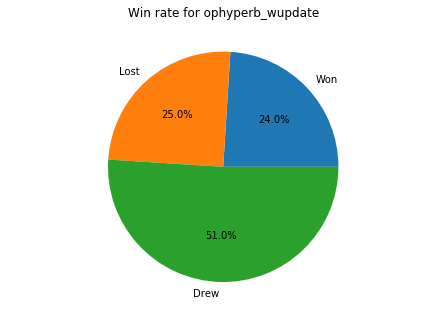

In [7]:
count_games_completed = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = len(data[idx]['player_1_score'])
    count_games_completed.append(total_count)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)| (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()

It is now worth looking into how performance degrades with fewer probes.

First I will consider the number of games that can be completed without error compared to the number of probes.

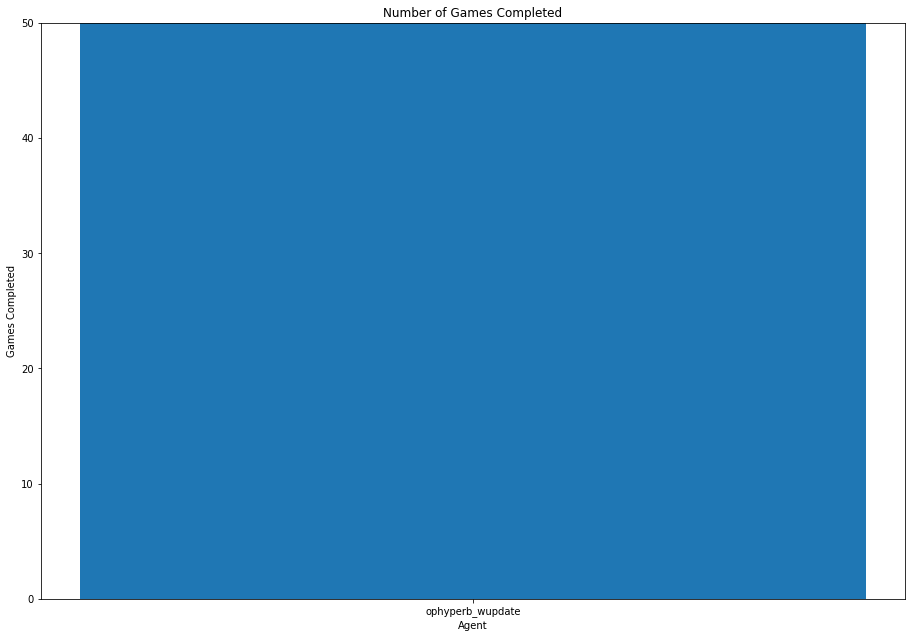

In [8]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2], label='state_update')
ax1.set_title('Number of Games Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Completed')
ax1.set_yscale('linear')
ax1.set_ylim([0,50])
ax1.bar(numNames, count_games_completed)
plt.show()

I will now consider whether the number of games won

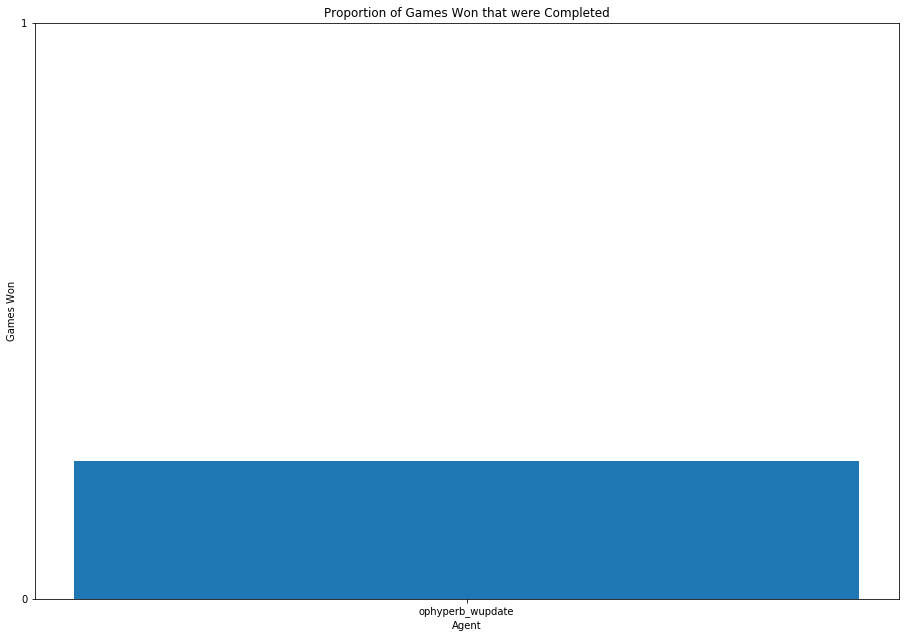

In [9]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,2])
ax1.set_title('Proportion of Games Won that were Completed')
ax1.set_xlabel('Agent')
ax1.set_ylabel('Games Won')
ax1.set_yscale('linear')
ax1.set_yticks(range(0,2,1))
ax1.set_ylim([0,1])
ax1.bar(numNames, np.divide(win_count,count_games_completed))
plt.show()

I will now consider the games that were not completed as losses and see how this affects the final score

The win/draw rate for the agent "OPHYPERB" playing the game "kriegTTT_4x4" with ophyperb_wupdate probes is 150.00% for 50 games


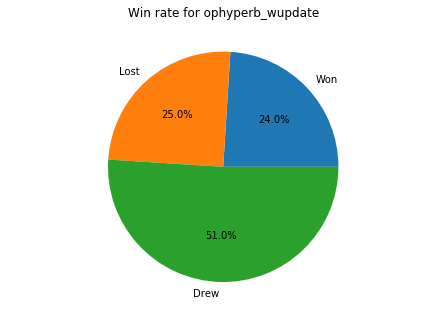

In [10]:
count_games_completed = list()
for idx, game in enumerate(data):
    total_score = data[idx]['player_1_score'][data[idx]['player_1_score'] >= 50].count() * 100
    total_count = 50
    count_games_completed.append(total_count)
    print(f"The win/draw rate for the agent \"" + str(data[idx]['player_1'][0]) + "\" playing the game \"" + str(data[idx]['game_name'][0]) + "\" with " + str(numNames[idx]) + f" probes is {(total_score/total_count):.2f}% for " + str(total_count) + " games")

# Display a pie chart
fig = plt.figure()
data_len = len(data)
win_count = list()
for idx, game in enumerate(data):
    ax = fig.add_axes([(data_len - idx)%2,math.ceil((data_len - idx)/2),1,1])
    ax.axis('equal')
    ax.set_title('Win rate for ' + str(numNames[idx]))
    result = ['Won', 'Lost', 'Drew']
    if data[idx]['player_1'][0] == 'HYPER':
        game_count = [(len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)])), (len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)])) + 15, (len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100)]))]
    else:
        game_count = [len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 0)]), len(game[(game['player_1_score'] == 0) & (game['player_2_score'] == 100)]), len(game[(game['player_1_score'] == 100) & (game['player_2_score'] == 100) | (game['player_1_score'] == 50) & (game['player_2_score'] == 50)])]
    win_count.append(game_count[0])
    ax.pie(game_count, labels = result,autopct='%1.1f%%')
plt.show()